In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time, json
import sys
sys.path.append("../")
# sys.path.append("../chess_llm_interpretability")
import os
import torch
import numpy as np

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-10-24 15:16:15 __main__ INFO     torch.__version__='2.4.1+cu121', torch.version.cuda='12.1'


In [3]:
from src.models import ModelandTokenizer

# MODEL_KEY = "meta-llama/Llama-3.2-3B-Instruct"
# MODEL_KEY = "meta-llama/Llama-3.1-8B-Instruct"

# MODEL_KEY = "meta-llama/Llama-3.2-3B"
# MODEL_KEY = "google/gemma-2-2b"
# MODEL_KEY = "meta-llama/Llama-3.1-8B"
MODEL_KEY = "meta-llama/Llama-3.2-3B"

mt = ModelandTokenizer(
    model_key=MODEL_KEY,
    # torch_dtype=torch.float32,
)

2024-10-24 15:16:16 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

2024-10-24 15:16:18 src.models INFO     loaded model </home/local_arnab/Codes/00_MODEL/meta-llama/Llama-3.2-3B> | size: 6127.841 MB | dtype: torch.float16 | device: cuda:0


In [ ]:
mt

### Verify Causal Tracing

In [212]:
def get_prompt(template, examples, query):
    prompt = ""
    for w1, w2, result in examples:
        prompt += f"{template.format(w1, w2)} {result}\n"
    prompt += f"{template.format(*query)}" 
    return prompt


template = "The Spanish word \"{}\" means \"{}\" in English. This statement is:"
examples = [
    ("aire", "silver", "FALSE"),
    ("jirafa", "giraffe", "TRUE"),
    ("luz", "light", "TRUE"),
    ("mesa", "mat", "False")
]

query_base = ("uno", "floor")
prompt_base = get_prompt(template, examples, query_base)
# print(prompt_patch)

query_patch = ("uno", "one")
prompt_patch = get_prompt(template, examples, query_patch)

In [215]:
print(prompt_base)

The Spanish word "aire" means "silver" in English. This statement is: FALSE
The Spanish word "jirafa" means "giraffe" in English. This statement is: TRUE
The Spanish word "luz" means "light" in English. This statement is: TRUE
The Spanish word "mesa" means "mat" in English. This statement is: False
The Spanish word "uno" means "floor" in English. This statement is:


In [5]:
# prompt_template = "{} is located in the city of"

# clean_subj = "Louvre"
# prompt_base = prompt_template.format(clean_subj)

# patched_subj = "The Space Needle"
# prompt_patch = prompt_template.format(patched_subj)

In [6]:
from src.functional import predict_next_token

base_ans = predict_next_token(
    mt = mt, inputs = prompt_base
)[0][0]

patch_ans = predict_next_token(
    mt = mt, inputs = prompt_patch
)[0][0]

print(f"Base answer: {base_ans}")
print(f"Patch answer: {patch_ans}")

assert base_ans.token_id != patch_ans.token_id, "The answers should be different."

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/torch/_subclasses/fake_tensor.py:2039: UserWarning: Accessing the data pointer of FakeTensor is deprecated and will error in PyTorch 2.5. This is almost definitely a bug in your code and will cause undefined behavior with subsystems like torch.compile. Please wrap calls to tensor.data_ptr() in an opaque custom op; If all else fails, you can guard accesses to tensor.data_ptr() on isinstance(tensor, FakeTensor). (Triggered internally at ../c10/core/StorageImpl.cpp:31.)
  return func(*args, **kwargs)
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Base answer: " FALSE" (p=0.383)
Patch answer: " TRUE" (p=0.555)


In [38]:
from src.trace import trace_important_states

# trace_results = trace_important_states(
#     mt=mt,
#     prompt_template=prompt_template,
#     clean_subj=clean_subj,
#     patched_subj=patched_subj,
#     window_size=1
# )

trace_results = trace_important_states(
    mt=mt,
    prompt_template=prompt_base.replace(query_base[1], "{}"),
    clean_subj=query_base[1],
    patched_subj=query_patch[1],
    window_size=1,
    ignore_few_shot_examples=True,
    few_shot_delimiter="\n"
)

tensor(128000, device='cuda:0') [128000, 128001]
2024-10-23 14:50:32 src.trace DEBUG    1
The Spanish word "aire" means "silver" in English. This statement is: FALSE
The Spanish word "jirafa" means "giraffe" in English. This statement is: TRUE
The Spanish word "luz" means "light" in English. This statement is: TRUE
The Spanish word "mesa" means "mat" in English. This statement is: False
The Spanish word "uno" means "floor" in English. This statement is:
2024-10-23 14:50:32 src.trace DEBUG    trace_start_idx updated to 82
2024-10-23 14:50:32 src.trace DEBUG    82
2024-10-23 14:50:35 src.trace DEBUG    answer=PredictedToken(token=' TRUE', prob=0.5550426840782166, logit=22.734375, token_id=8378)
2024-10-23 14:50:35 src.trace DEBUG    clean_answer=PredictedToken(token=' FALSE', prob=0.38274797797203064, logit=22.15625, token_id=7989)
2024-10-23 14:50:35 src.trace DEBUG    track_ans=[(3, PredictedToken(token=' TRUE', prob=0.15707945823669434, logit=21.265625, token_id=8378))]
2024-10-23 14:

100%|██████████| 504/504 [04:21<00:00,  1.92it/s]


2024-10-23 14:55:12 matplotlib DEBUG    matplotlib data path: /home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data
2024-10-23 14:55:12 matplotlib DEBUG    CONFIGDIR=/home/local_arnab/.config/matplotlib
2024-10-23 14:55:12 matplotlib DEBUG    interactive is False
2024-10-23 14:55:12 matplotlib DEBUG    platform is linux
2024-10-23 14:55:12 matplotlib DEBUG    CACHEDIR=/home/local_arnab/.cache/matplotlib
2024-10-23 14:55:12 matplotlib.font_manager DEBUG    Using fontManager instance from /home/local_arnab/.cache/matplotlib/fontlist-v330.json


2024-10-23 14:55:12 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-10-23 14:55:12 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-10-23 14:55:12 matplotlib.font_manager DEBUG    findfont: Matching Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0.
2024-10-23 14:55:12 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-10-23 14:55:12 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='norm

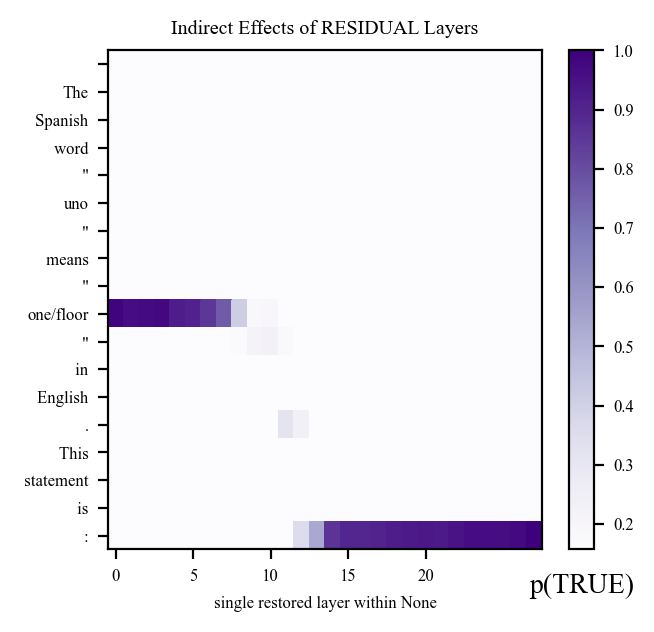

In [39]:
from src.plotting import plot_trace_heatmap

plot_trace_heatmap(trace_results)

### Dataset Parsing

In [ ]:
from src.dataset import GMTDataset

ds_sp_en = GMTDataset.from_csv("sp_en_trans.csv", "SP to EN")

2024-10-24 15:16:20 numexpr.utils INFO     Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-10-24 15:16:20 numexpr.utils INFO     NumExpr defaulting to 8 threads.
2024-10-24 15:16:20 src.dataset DEBUG    initialized SP to EN with 348 examples.


In [ ]:
ds_cities = GMTDataset.from_csv(
    [
        # "sp_en_trans.csv", 
        "cities.csv"
    ], 
    "Cities"
)

2024-10-24 15:16:20 src.dataset DEBUG    initialized Cities with 1493 examples.


In [9]:
ds_cities.select_few_shot(0)
ds_sp_en.select_few_shot(0)

In [10]:
ques, ans = ds_cities[25]

print(f"\"{ques}\"")
print(f"\"{ans}\"")

"The city of Kano is in China. This statement is:"
" FALSE"


### Check separability of labels

In [ ]:
from src.functional import predict_next_token
predict_next_token(
    mt=mt,
    inputs=ques
)

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


[[PredictedToken(token=' true', prob=0.07568001002073288, logit=13.4765625, token_id=837),
  PredictedToken(token=' True', prob=0.06944788247346878, logit=13.390625, token_id=3082),
  PredictedToken(token=' (', prob=0.05624060705304146, logit=13.1796875, token_id=320),
  PredictedToken(token=' a', prob=0.05041376128792763, logit=13.0703125, token_id=264),
  PredictedToken(token=' false', prob=0.029869163408875465, logit=12.546875, token_id=905)]]

In [22]:
from src.functional import get_concept_latents

queries = [ds_cities[i] for i in range(len(ds_cities))]
interested_layers = mt.layer_names

latents = get_concept_latents(
    mt=mt, 
    queries=queries, 
    interested_layers=interested_layers,
    check_answer=False,
)

  0%|          | 0/1496 [00:00<?, ?it/s]

100%|██████████| 1496/1496 [14:27<00:00,  1.73it/s]

2024-10-24 15:49:16 src.functional DEBUG    Collected 1496 latents, out of 1496


In [23]:
from src.analysis import PCA

layer = interested_layers[10]

X = torch.stack([l["latents"][layer] for l in latents]).to(torch.float32).to("cuda")

pca = PCA(n_components=2)
X2 = pca.fit_transform(X)

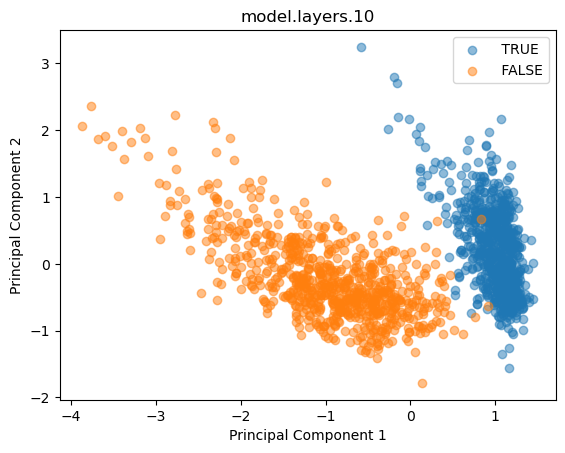

In [25]:
import matplotlib.pyplot as plt

def show_scatter_plot(X, y):
    points_by_label = {l: [] for l in set(y)}
    for point, label in zip(X, y):
        points_by_label[label].append(point.cpu())

    for l in points_by_label:
        points_by_label[l] = np.array(points_by_label[l])
        plt.scatter(points_by_label[l][:, 0], points_by_label[l][:, 1], label=l, alpha=0.5) 

    plt.legend()
    plt.title(layer)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    plt.show()


y = [l["answer"] for l in latents]
show_scatter_plot(X2, y) 

In [26]:
queries = [ds_sp_en[i] for i in range(len(ds_sp_en))]
interested_layers = mt.layer_names

latents_sp_en = get_concept_latents(
    mt=mt, 
    queries=queries, 
    interested_layers=interested_layers,
    check_answer=False,
)

  0%|          | 0/351 [00:00<?, ?it/s]

100%|██████████| 351/351 [03:37<00:00,  1.62it/s]

2024-10-24 15:53:30 src.functional DEBUG    Collected 351 latents, out of 351


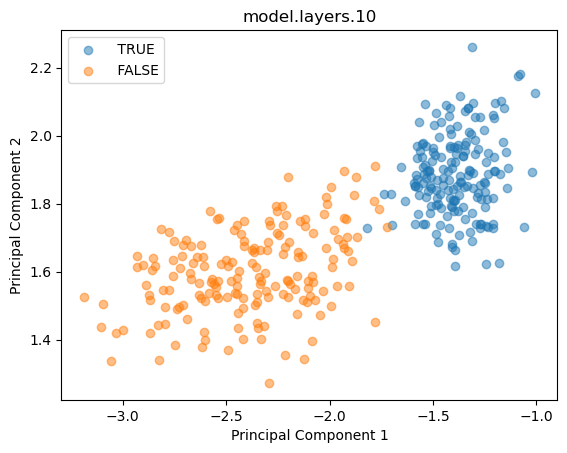

In [27]:
X_sp_en = torch.stack([l["latents"][layer] for l in latents_sp_en]).to(torch.float32).to("cuda")
X2_sp_en = pca.transform(X_sp_en)
y_sp_en = [l["answer"] for l in latents_sp_en]

show_scatter_plot(X2_sp_en, y_sp_en)

### Linear Probe Pipeline

In [28]:
from src.analysis import LinearProbe
# probe = LinearProbe(input_dim=X.shape[1], n_classes=len(set(y)))

probe = LinearProbe.from_data(
    X[:1000], y[:1000], 
    epochs=1000,
    validation_set=(X[1000:], y[1000:]),
)
probe

2024-10-24 15:55:24 src.analysis DEBUG    Epoch 100/1000, Loss: 0.5333519577980042, Validation Accuracy: 0.9657
2024-10-24 15:55:24 src.analysis DEBUG    Epoch 200/1000, Loss: 0.4535371661186218, Validation Accuracy: 0.9819
2024-10-24 15:55:24 src.analysis DEBUG    Epoch 300/1000, Loss: 0.4133288264274597, Validation Accuracy: 0.9899
2024-10-24 15:55:24 src.analysis DEBUG    Epoch 400/1000, Loss: 0.38997140526771545, Validation Accuracy: 0.9919
2024-10-24 15:55:24 src.analysis DEBUG    Epoch 500/1000, Loss: 0.37494444847106934, Validation Accuracy: 0.9960


2024-10-24 15:55:24 src.analysis DEBUG    Epoch 600/1000, Loss: 0.3645530939102173, Validation Accuracy: 0.9980
2024-10-24 15:55:24 src.analysis DEBUG    Epoch 700/1000, Loss: 0.3569760024547577, Validation Accuracy: 0.9980
2024-10-24 15:55:24 src.analysis DEBUG    Epoch 800/1000, Loss: 0.3512234389781952, Validation Accuracy: 0.9980
2024-10-24 15:55:24 src.analysis DEBUG    Epoch 900/1000, Loss: 0.3467153012752533, Validation Accuracy: 0.9980
2024-10-24 15:55:24 src.analysis DEBUG    Epoch 1000/1000, Loss: 0.34309113025665283, Validation Accuracy: 0.9980
2024-10-24 15:55:24 src.analysis INFO     LinearProbe validation accuracy: 0.9980


LinearProbe(
  (linear): Linear(in_features=3072, out_features=2, bias=False)
  (class_head): Softmax(dim=-1)
)

In [29]:
# OOD validation
probe.validate(X_sp_en, y_sp_en)

0.5042735042735043

In [30]:
# Save the probe
probe.save("linear_probe.pt")

In [31]:
loaded_probe = LinearProbe.from_pretained("linear_probe.pt").to("cuda")
loaded_probe.validate(X_sp_en, y_sp_en)

/home/local_arnab/Codes/Projects/talkative_probes/notebooks/../src/analysis.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt = torch.load(path)


0.5042735042735043

In [32]:
latents[0].keys()  # Check the keys of the first latent

dict_keys(['question', 'question_tokenized', 'answer', 'prediction', 'query_token_idx', 'latents'])

### Test concept presence with linear probe

In [33]:
def check_concept_presence_with_LR(
    activations,
    layer_name_format,
    interested_layer_indices,
    device = "cuda",
    validation_split = 0.2,
    test_activations = None,
):
    validation_acc = []
    ood_test_acc = []

    train_split = int(len(activations) * (1 - validation_split))

    for l_idx in range(interested_layer_indices):
        layer_name = layer_name_format.format(l_idx)
        layer_X = torch.stack([l["latents"][layer_name] for l in activations]).to(torch.float32).to(device)
        layer_y = [l["answer"] for l in activations]

        probe = LinearProbe.from_data(
            layer_X[:train_split], layer_y[:train_split], 
            epochs=1000,
            name=layer_name,
            print_logs=False
        )

        val_acc = probe.validate(layer_X[train_split:], layer_y[train_split:])
        validation_acc.append(val_acc)

        log_msg = f"{layer_name}: {val_acc:.4f}"

        if test_activations is not None:
            layer_X_test = torch.stack([l["latents"][layer_name] for l in test_activations]).to(torch.float32).to(device)
            layer_y_test = [l["answer"] for l in test_activations]

            test_acc = probe.validate(layer_X_test, layer_y_test)
            ood_test_acc.append(test_acc)
            log_msg += f", test acc: {test_acc:.4f}"
        
        logger.info(log_msg)
        
    if ood_test_acc:
        return validation_acc, ood_test_acc
    return validation_acc


# Check concept presence with linear regression
val_acc, ood_acc = check_concept_presence_with_LR(
    latents,
    layer_name_format=mt.layer_name_format,
    interested_layer_indices=len(interested_layers),
    test_activations=latents_sp_en
)


2024-10-24 15:55:52 __main__ INFO     model.layers.0: 0.4500, test acc: 0.5043
2024-10-24 15:55:52 __main__ INFO     model.layers.1: 0.5333, test acc: 0.5271
2024-10-24 15:55:53 __main__ INFO     model.layers.2: 0.5700, test acc: 0.5613
2024-10-24 15:55:53 __main__ INFO     model.layers.3: 0.7033, test acc: 0.5755
2024-10-24 15:55:54 __main__ INFO     model.layers.4: 0.9133, test acc: 0.5043
2024-10-24 15:55:54 __main__ INFO     model.layers.5: 0.9067, test acc: 0.5043
2024-10-24 15:55:54 __main__ INFO     model.layers.6: 0.9567, test acc: 0.6239
2024-10-24 15:55:55 __main__ INFO     model.layers.7: 0.9700, test acc: 0.5043
2024-10-24 15:55:55 __main__ INFO     model.layers.8: 0.9933, test acc: 0.5214
2024-10-24 15:55:56 __main__ INFO     model.layers.9: 0.9933, test acc: 0.5071
2024-10-24 15:55:56 __main__ INFO     model.layers.10: 0.9967, test acc: 0.5043
2024-10-24 15:55:57 __main__ INFO     model.layers.11: 0.9967, test acc: 0.5043
2024-10-24 15:55:57 __main__ INFO     model.layers

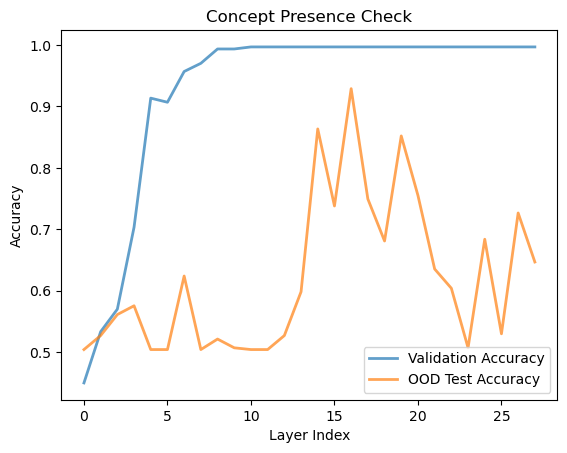

In [34]:
from matplotlib import pyplot as plt

plt.plot(val_acc, linewidth=2, alpha=0.7, label='Validation Accuracy')
plt.plot(ood_acc, linewidth=2, alpha=0.7, label='OOD Test Accuracy')
plt.xlabel('Layer Index')
plt.ylabel('Accuracy')
plt.title('Concept Presence Check')
plt.legend()
plt.show()

In [ ]:
arr = [1,2,3]
arr